In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")

#set fig width & height in inches (References: https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot)
from matplotlib.pylab import rcParams
rcParams ['figure.figsize'] = 16,4
rcParams.update({'font.size': 13})

In [3]:
train_df = pd.read_csv("CPI_train.csv")
print(train_df.shape)

(124, 2)


In [4]:
test_df = pd.read_csv("CPI_test.csv")
print(test_df.shape)

(8, 2)


In [5]:
train_df['Quarter'] = pd.to_datetime(train_df['Quarter'], format = '%Y-%m-%d')
train_df.set_index('Quarter', inplace = True)
train_df.head()

,CPI
Quarter,
1990-03-01,43.513571
1990-06-01,43.993571
1990-09-01,44.593571
1990-12-01,46.633571
1991-03-01,48.673571


In [6]:
test_df['Quarter'] = pd.to_datetime(test_df['Quarter'], format = '%m/%d/%Y')
test_df.set_index('Quarter', inplace = True)
test_df.head()

,CPI
Quarter,
2021-03-01,127
2021-06-01,128
2021-09-01,129
2021-12-01,130
2022-03-01,131


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 1990-03-01 to 2020-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CPI     124 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


In [8]:
train_df.describe()

,CPI
count,124.000000
mean,97.997442
std,37.232244
min,43.513571
25%,67.123571
50%,89.233571
75%,129.403571
max,169.633571


In [9]:
train_df.isnull().sum()

CPI    0
dtype: int64

# Train-validation split for model seletion 


In [10]:
validation_set = train_df[-8:]
validation_set

,CPI
Quarter,
2019-03-01,163.273571
2019-06-01,166.153571
2019-09-01,165.793571
2019-12-01,165.313571
2020-03-01,168.073571
2020-06-01,167.713571
2020-09-01,167.473571
2020-12-01,169.633571


In [11]:
train_set = train_df[:-8]
train_set.shape

(116, 1)

In [12]:
train_set

,CPI
Quarter,
1990-03-01,43.513571
1990-06-01,43.993571
1990-09-01,44.593571
1990-12-01,46.633571
1991-03-01,48.673571
...,...
2017-12-01,154.993571
2018-03-01,158.353571
2018-06-01,161.353571


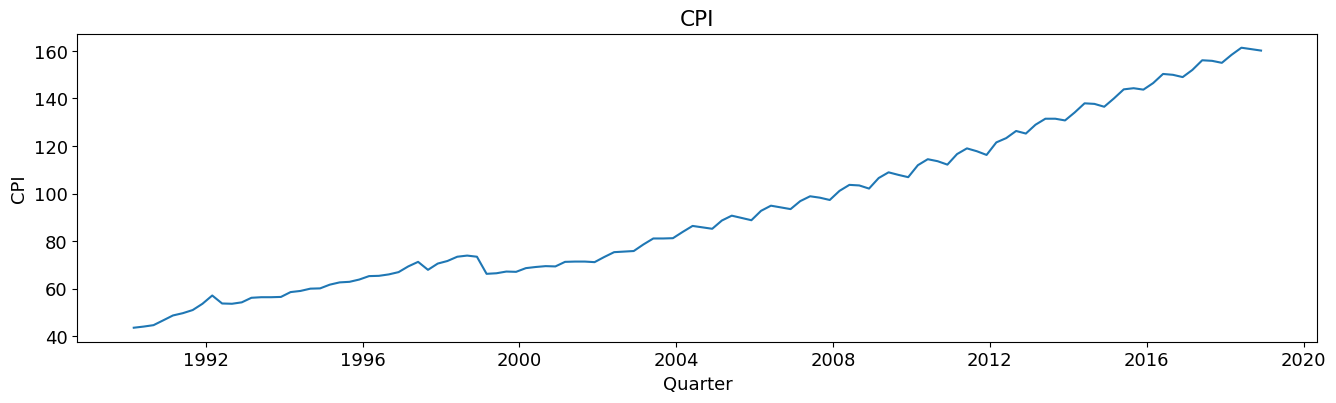

In [13]:
plt.figure()
plt.plot(train_set["CPI"])
plt.title('CPI')
plt.xlabel('Quarter')
plt.ylabel('CPI')
plt.savefig("fig1",bbox_inches = 'tight')

# Decomposition


Initial trend estimate (MA)

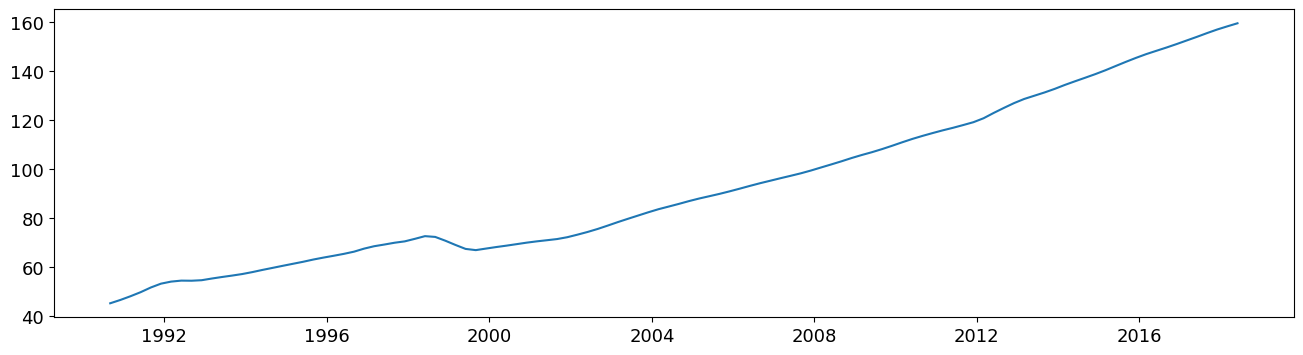

In [14]:
# Center Moving Average Smoothing to reveal trend
plt.figure()
CPI_trend = train_set.rolling(4, center = True).mean().rolling(2,center = True).mean().shift(-1)
plt.plot(CPI_trend)
plt.savefig("fig2",bbox_inches = 'tight')

In [15]:
CPI_trend

,CPI
Quarter,
1990-03-01,NaN
1990-06-01,NaN
1990-09-01,45.328571
1990-12-01,46.678571
1991-03-01,48.178571
...,...
2017-12-01,156.973571
2018-03-01,158.248571
2018-06-01,159.508571


De-trend

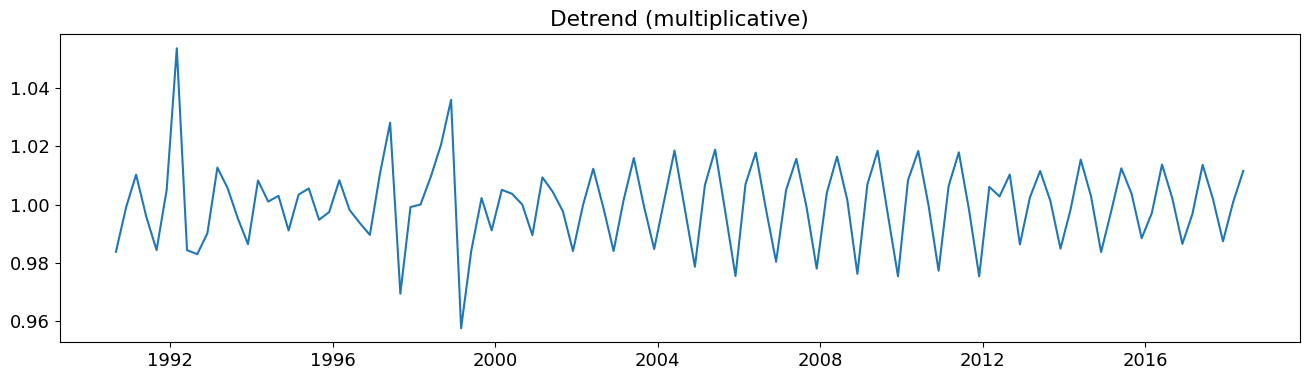

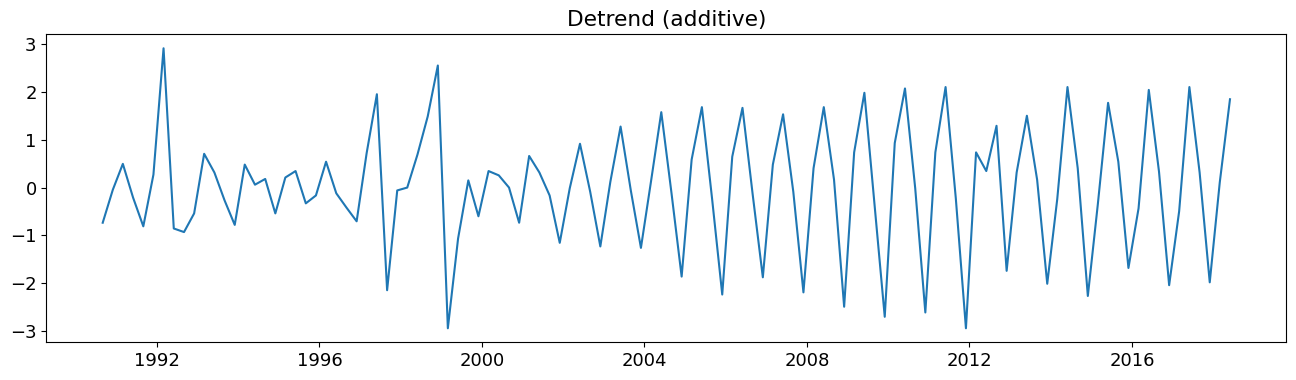

In [16]:
# Remove the trend component with both decomposition method
detrend_multi = train_set / CPI_trend
plt.figure()
plt.title('Detrend (multiplicative)')
plt.plot(detrend_multi)

detrend_addti = train_set - CPI_trend
plt.figure()
plt.title('Detrend (additive)')
plt.plot(detrend_addti)

plt.savefig("fig3",bbox_inches = 'tight')

### Now we assume the data use mulplicative decomposition

In [17]:
detrend_multi.shape

(116, 1)

In [18]:
# Repalce missing values with 0
detrend_multi_zero = np.nan_to_num(detrend_multi)

# Reshape the de-trended series to a table
quarterly_S = np.reshape(detrend_multi_zero,(29,4))

quarterly_avg = np.mean(quarterly_S[1:28,:],axis=0)

quarterly_avg

array([1.00461059, 1.00966021, 0.99829265, 0.98747668])

In [19]:
# Normalize the seasonal index
seasonal_idx = quarterly_avg.mean()

seasonal_idx_normalized = quarterly_avg /seasonal_idx

print(seasonal_idx_normalized.mean())
seasonal_idx_normalized

1.0


array([1.00460051, 1.00965008, 0.99828264, 0.98746677])

In [20]:
# Replicate the normalized seasonal index array 12 times
seasonal = np.tile(seasonal_idx_normalized, 29)
seasonal = np.reshape(seasonal, (29*4,1))

seasonally_adjusted = train_set/seasonal

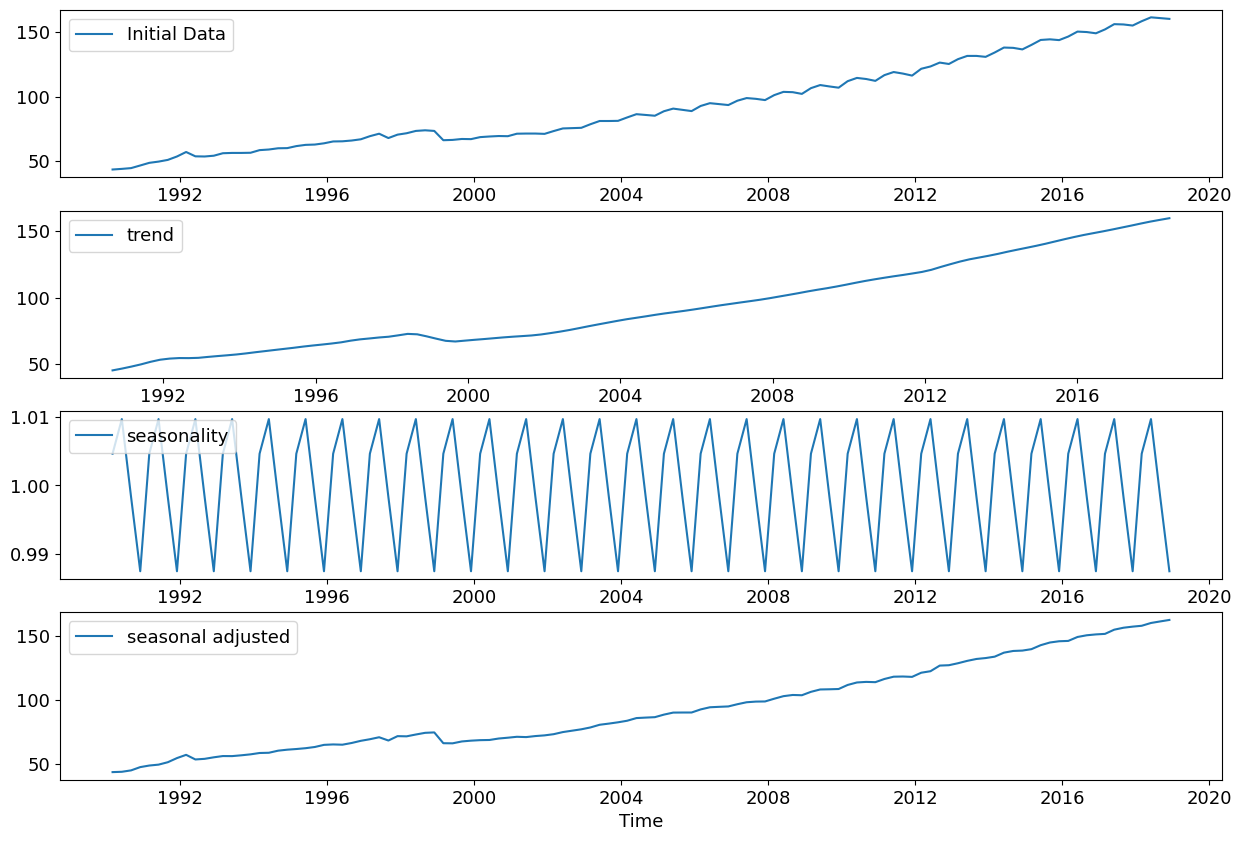

In [21]:
fig, ax = plt.subplots(4, 1,figsize=(15,10))
ax[0].plot(train_set)
ax[1].plot(CPI_trend)
ax[2].plot(train_set.index,seasonal)
ax[3].plot(seasonally_adjusted)
ax[0].legend(['Initial Data'], loc=2)
ax[1].legend(['trend'], loc=2)
ax[2].legend(['seasonality'], loc=2)
ax[3].legend(['seasonal adjusted'], loc=2)
plt.xlabel('Time')
plt.savefig("fig4",bbox_inches = 'tight')

### Restimate the trend-cycle component based on the seasonally adjusted data

In [22]:
Trend = seasonally_adjusted.rolling(2, center = True).mean().rolling(2,center = True).mean().shift(-1)[1:-1]

In [23]:
Trend.shape

(114, 1)

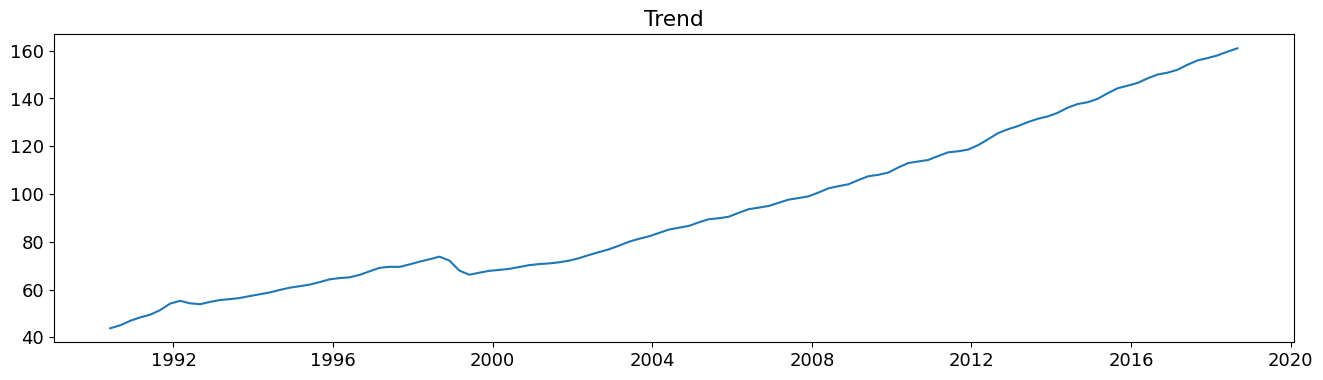

In [24]:
plt.figure()
plt.title('Trend')
plt.plot(Trend)
plt.savefig("fig5",bbox_inches = 'tight')

###  Decomposition Forecast

In [25]:
trend_list = list(Trend["CPI"])
for i in range(8+1):
    trend_list.append(np.mean(trend_list[-2:]))

In [26]:
len(trend_list)

123

In [27]:
forecast_trend = trend_list[-8:]
forecast_trend

[160.65343663003773,
 160.47291698993195,
 160.56317680998484,
 160.5180468999584,
 160.54061185497162,
 160.529329377465,
 160.5349706162183,
 160.53214999684164]

In [28]:
forecast_seaonality = seasonal[-8:]
forecast_seaonality

array([[1.00460051],
       [1.00965008],
       [0.99828264],
       [0.98746677],
       [1.00460051],
       [1.00965008],
       [0.99828264],
       [0.98746677]])

In [29]:
forecasts_decomp = []
for i in range(0, len(forecast_trend)):
    forecasts_decomp.append(forecast_trend[i] * forecast_seaonality[i])

In [30]:
len(forecasts_decomp)

8

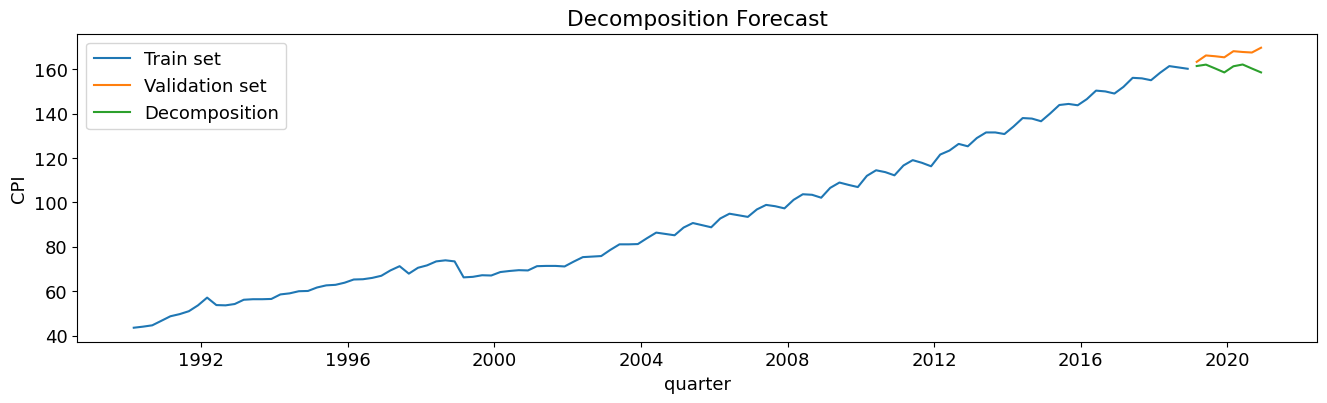

In [31]:
plt.figure()
plt.plot(train_set, label = "Train set")
plt.plot(validation_set, label = "Validation set")
plt.plot(list(validation_set.index),forecasts_decomp, label = "Decomposition")
plt.title('Decomposition Forecast')
plt.xlabel('quarter')
plt.ylabel('CPI')
plt.legend()
plt.savefig("fig6",bbox_inches = 'tight')

### MSE for Decomposition Forecasting Method

In [32]:
def MSE(y,y_hat):
    return np.mean(np.power(y-y_hat, 2))

In [33]:
forecasts_decomp_array = np.array(forecasts_decomp).reshape(-1,1)
validation_array = np.array(validation_set)

In [34]:
MSE_decomp = MSE(validation_array, forecasts_decomp_array)
MSE_decomp = MSE_decomp.round(4)
MSE_decomp

43.8428

# Seasonal Naive


In [35]:
train_df = pd.read_csv("CPI_train.csv")
train_df['Quarter'] = pd.to_datetime(train_df['Quarter'], format = '%Y-%m-%d')
train_df.set_index('Quarter', inplace = True)

validation_set_seasonal = train_df[-8:]
train_set_seasonal = train_df[:-8]

print(validation_set_seasonal.shape)
print(train_set_seasonal.shape)

(8, 1)
(116, 1)


In [36]:
M = 4

seasonal_naive = pd.Series(np.zeros(len(validation_set_seasonal)))[:4]
seasonal_naive.index = validation_set_seasonal[:4].index

for i in np.arange(len(validation_set_seasonal[:4])):
    seasonal_naive[i] = train_df["CPI"][len(train_set_seasonal)+i-M]
    
seasonal_naive

Quarter
2019-03-01    158.353571
2019-06-01    161.353571
2019-09-01    160.753571
2019-12-01    160.153571
dtype: float64

In [37]:
seasonal_naive_list = list(seasonal_naive)*2
seasonal_naive_list

[158.3535711683798,
 161.3535711683798,
 160.7535711683798,
 160.15357116837978,
 158.3535711683798,
 161.3535711683798,
 160.7535711683798,
 160.15357116837978]

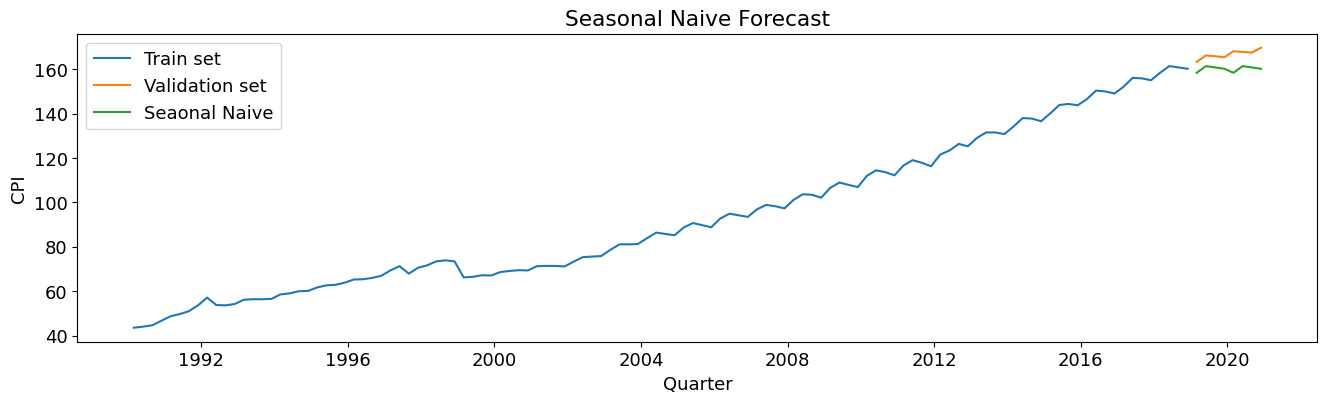

In [38]:
plt.figure()
plt.plot(train_set, label = "Train set")
plt.plot(validation_set, label = "Validation set")
plt.plot(validation_set.index,seasonal_naive_list, label = "Seaonal Naive")
plt.title('Seasonal Naive Forecast')
plt.xlabel('Quarter')
plt.ylabel('CPI')
plt.legend()
plt.savefig("fig7",bbox_inches = 'tight')

### MSE for Seasonal Naive Forecasting Method

In [39]:
def MSE(y,y_hat):
    return np.mean(np.power(y-y_hat, 2))

In [40]:
forecasts_seasonal_array = np.array(seasonal_naive_list).reshape(-1,1)
validation_array = np.array(validation_set)

In [41]:
MSE_naive = MSE(validation_array, forecasts_seasonal_array)
MSE_naive = MSE_naive.round(4)
MSE_naive

46.1538

# Drift method


In [42]:
train_df = pd.read_csv("CPI_train.csv")
train_df['Quarter'] = pd.to_datetime(train_df['Quarter'], format = '%Y-%m-%d')
train_df.set_index('Quarter', inplace = True)

validation_set_drift = train_df[-8:]
train_set_drift = train_df[:-8]

print(validation_set_drift.shape)
print(train_set_drift.shape)

(8, 1)
(116, 1)


In [43]:
y_T = train_set_drift['CPI'][-1]
y_1 = train_set_drift['CPI'][0]

drift_pred = []
for h in range(1, len(validation_set_drift)+1):
    drift_pred.append(y_T + h* (y_T - y_1)/ (len(train_set_drift)-1))

drift_pred

[161.167832037945,
 162.18209290751022,
 163.19635377707544,
 164.21061464664066,
 165.22487551620588,
 166.23913638577108,
 167.2533972553363,
 168.26765812490152]

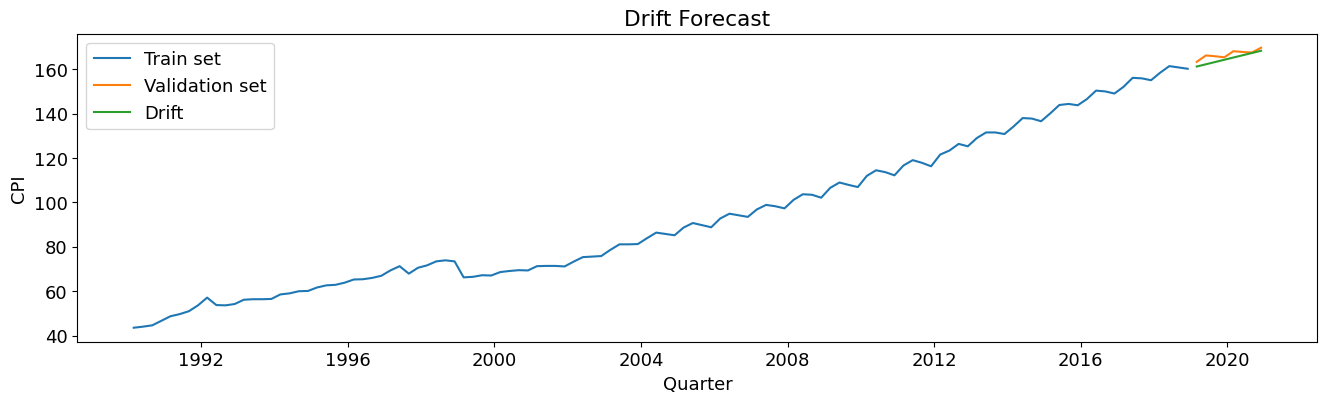

In [44]:
plt.figure()
plt.plot(train_set_drift, label = "Train set")
plt.plot(validation_set_drift, label = "Validation set")
plt.plot(validation_set_drift.index,drift_pred, label = "Drift")
plt.title('Drift Forecast')
plt.xlabel('Quarter')
plt.ylabel('CPI')
plt.legend()
plt.savefig("fig8",bbox_inches = 'tight')

### MSE for Drift Forecasting Method

In [45]:
def MSE(y,y_hat):
    return np.mean(np.power(y-y_hat, 2))

In [46]:
validation = np.array(validation_set_drift)
drift_pred = np.array(drift_pred).reshape(-1,1)

In [47]:
MSE_drift = MSE(validation, drift_pred)
MSE_drift = MSE_drift.round(4)
MSE_drift

5.0465

# Exponential Smoothing - Holt-Winters

In [48]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [49]:
train_df = pd.read_csv("CPI_train.csv")
train_df['Quarter'] = pd.to_datetime(train_df['Quarter'], format = '%Y-%m-%d')
train_df.set_index('Quarter', inplace = True)

validation_set_exponential = train_df[-8:]
train_set_exponential = train_df[:-8]

print(validation_set_exponential.shape)
print(train_set_exponential.shape)

(8, 1)
(116, 1)


## 1) Holt-Winter Additive Smoothing

In [50]:
fit_add = ExponentialSmoothing(train_set_exponential, seasonal_periods=4, trend='add', seasonal='add').fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


In [51]:
results_add = pd.DataFrame(index=[r"$\alpha$",\
                              r"$\beta$",\
                              r"$\gamma$",\
                              r"$l_0$",\
                              "$b_0$",\
                              "SSE"])

params = ['smoothing_level', \
          'smoothing_trend', \
          'smoothing_seasonal', \
          'initial_level', \
          'initial_trend']

results_add["Result"] = [fit_add.params[p] for p in params] + [fit_add.sse]

In [52]:
results_add.round(4)

,Result
$\alpha$,0.8046
$\beta$,0.0530
$\gamma$,0.1954
$l_0$,42.2883
$b_0$,0.9102
SSE,222.1155


In [53]:
predict_add = fit_add.forecast(8)

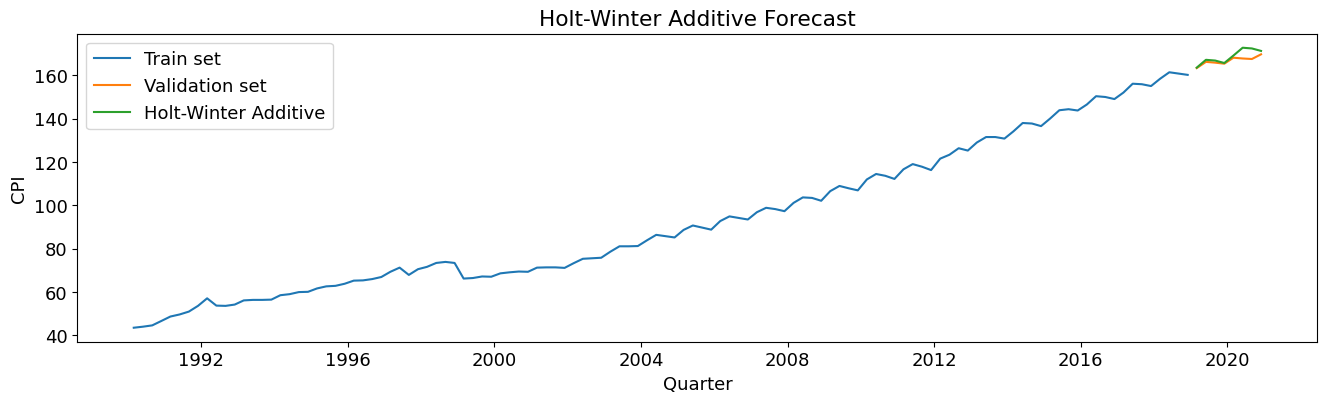

In [54]:
plt.figure()
plt.plot(train_set_exponential, label = "Train set")
plt.plot(validation_set_exponential, label = "Validation set")
plt.plot(validation_set_exponential.index,predict_add, label = "Holt-Winter Additive")
plt.title('Holt-Winter Additive Forecast')
plt.xlabel('Quarter')
plt.ylabel('CPI')
plt.legend()
plt.savefig("fig9",bbox_inches = 'tight')

In [55]:
def MSE(y,y_hat):
    return np.mean(np.power(y-y_hat, 2))

In [56]:
validation = np.array(validation_set_exponential)
predict_add = np.array(predict_add).reshape(-1,1)

In [57]:
MSE_HW_add = MSE(validation, predict_add)
MSE_HW_add = MSE_HW_add.round(4)
MSE_HW_add

6.7167

## 2) Holt-Winter Mulplicative Smoothing

In [58]:
fit_mul = ExponentialSmoothing(train_set_exponential, seasonal_periods=4, trend='add', seasonal='mul').fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


In [59]:
results_mul = pd.DataFrame(index=[r"$\alpha$",\
                              r"$\beta$",\
                              r"$\gamma$",\
                              r"$l_0$",\
                              "$b_0$",\
                              "SSE"])

params = ['smoothing_level', \
          'smoothing_trend', \
          'smoothing_seasonal', \
          'initial_level', \
          'initial_trend']

results_mul["Result"] = [fit_mul.params[p] for p in params] + [fit_mul.sse]

In [60]:
results_mul

,Result
$\alpha$,0.781988
$\beta$,0.052458
$\gamma$,0.218012
$l_0$,44.298633
$b_0$,0.948535
SSE,228.980505


In [61]:
predict_mul = fit_mul.forecast(8)

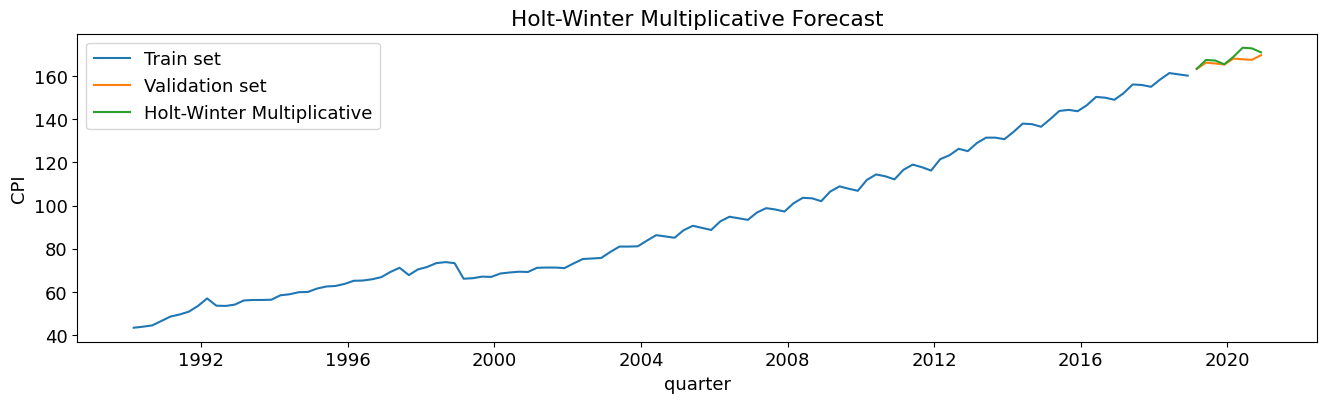

In [62]:
plt.figure()
plt.plot(train_set_exponential, label = "Train set")
plt.plot(validation_set_exponential, label = "Validation set")
plt.plot(validation_set_exponential.index,predict_mul, label = "Holt-Winter Multiplicative")
plt.title('Holt-Winter Multiplicative Forecast')
plt.xlabel('quarter')
plt.ylabel('CPI')
plt.legend()
plt.savefig("fig10",bbox_inches = 'tight')

In [63]:
def MSE(y,y_hat):
    return np.mean(np.power(y-y_hat, 2))

In [64]:
validation = np.array(validation_set_exponential)
predict_mul = np.array(predict_mul).reshape(-1,1)

In [65]:
MSE_HW_mul = MSE(validation, predict_mul)
MSE_HW_mul = MSE_HW_mul.round(4)
MSE_HW_mul

7.8762

# SARIMA

## Log Transformation

In [66]:
train_set_log = np.log(train_set)
train_set_log.head()

,CPI
Quarter,
1990-03-01,3.773073
1990-06-01,3.784044
1990-09-01,3.797590
1990-12-01,3.842321
1991-03-01,3.885136


## Check stationary of the original data

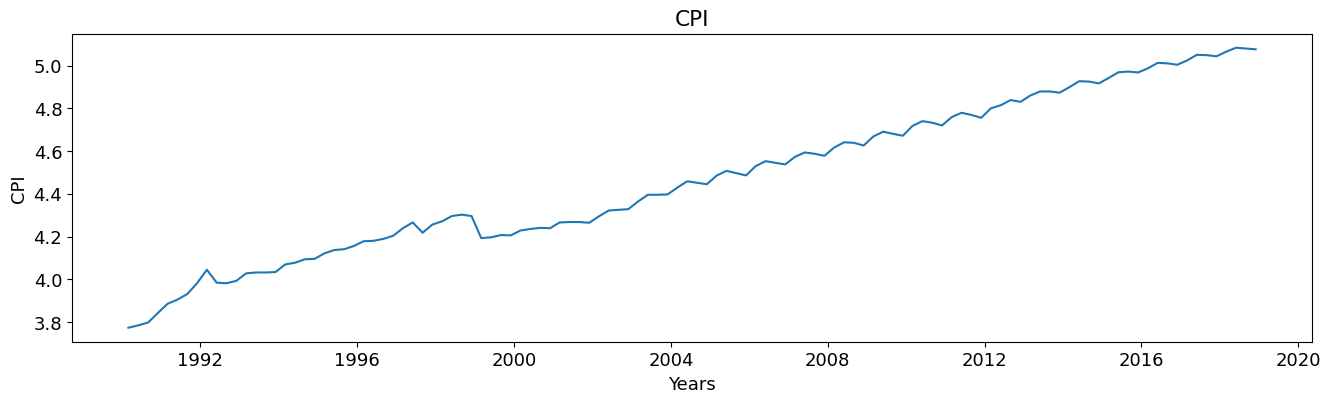

In [67]:
plt.figure()
plt.plot(train_set_log)
plt.xlabel('Years')
plt.ylabel('CPI')
plt.title('CPI')
plt.savefig("fig11",bbox_inches = 'tight')

<Figure size 1500x600 with 0 Axes>

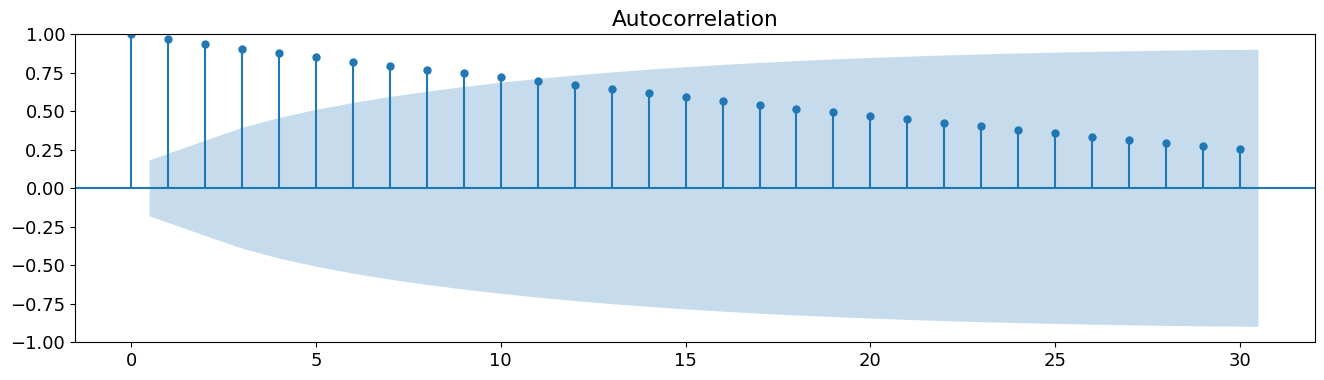

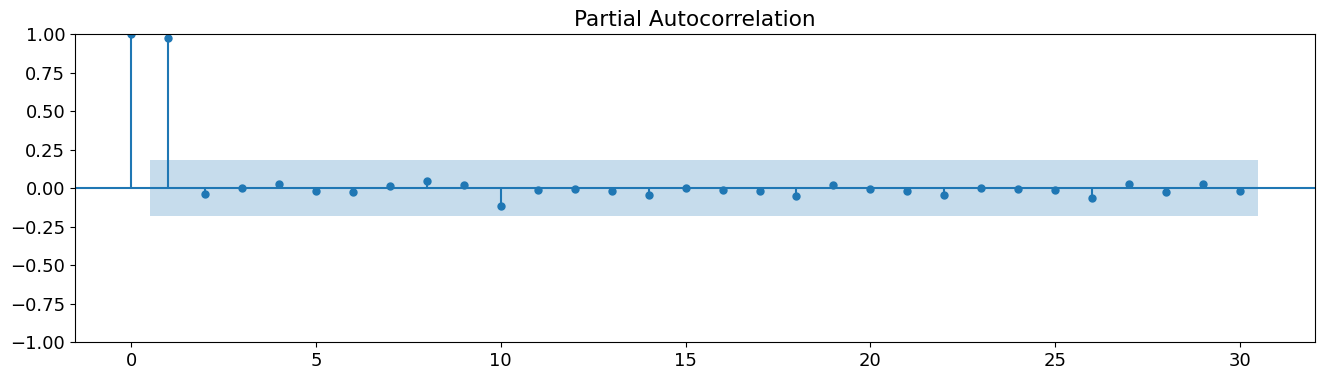

In [68]:
import statsmodels as sm
import statsmodels.api as smt

plt.figure(figsize=(15,6))
smt.graphics.tsa.plot_acf(train_set_log, lags=30, alpha = 0.05)
smt.graphics.tsa.plot_pacf(train_set_log, lags=30, alpha = 0.05)
plt.savefig("fig12",bbox_inches = 'tight')

##  Differencing Data

### $1^{st}$ order differencing (d=1)

In [69]:
# Calculate 1st-order differnencing(d=1), Y[1]-Y[0], Y[2]-Y[1],...
train_log_diff = pd.Series.diff(train_set_log)
train_log_diff

,0
Quarter,
1990-03-01,NaN
1990-06-01,0.010971
1990-09-01,0.013546
1990-12-01,0.044731
1991-03-01,0.042816
...,...
2017-12-01,-0.005405
2018-03-01,0.021447
2018-06-01,0.018768


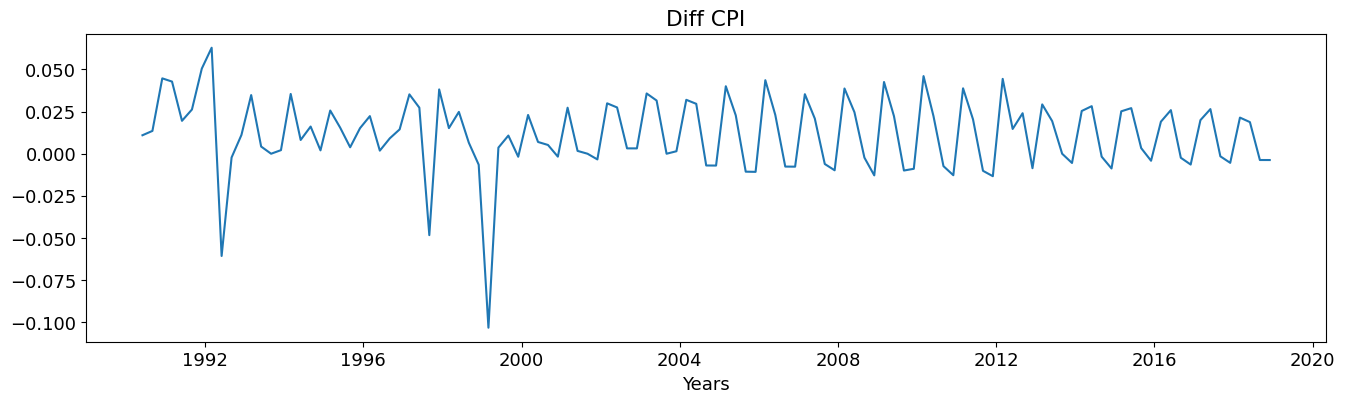

In [70]:
# Discard the nan value
train_log_diff = train_log_diff.dropna()

# Plot the differenced data
plt.figure()
plt.plot(train_log_diff)
plt.xlabel('Years')
plt.title('Diff CPI')
plt.savefig("1diff",bbox_inches = 'tight')

<Figure size 1500x600 with 0 Axes>

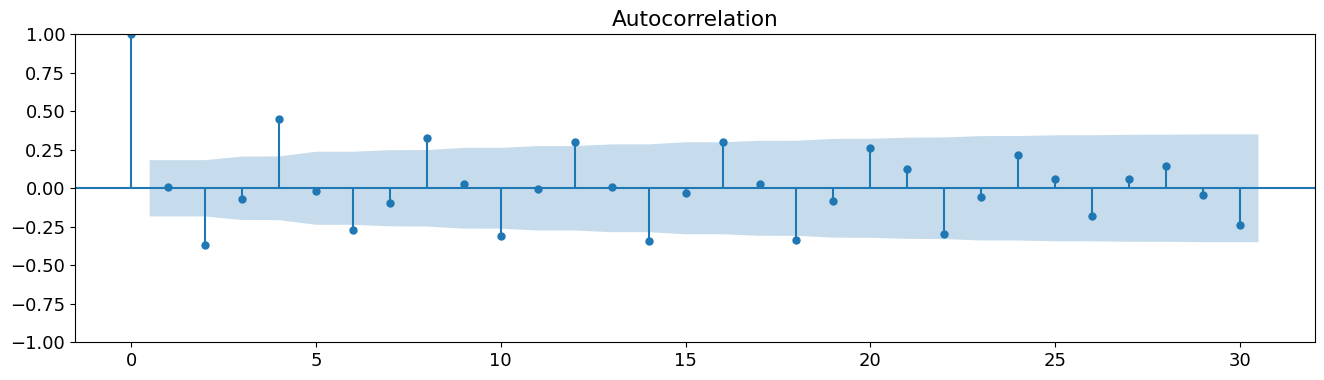

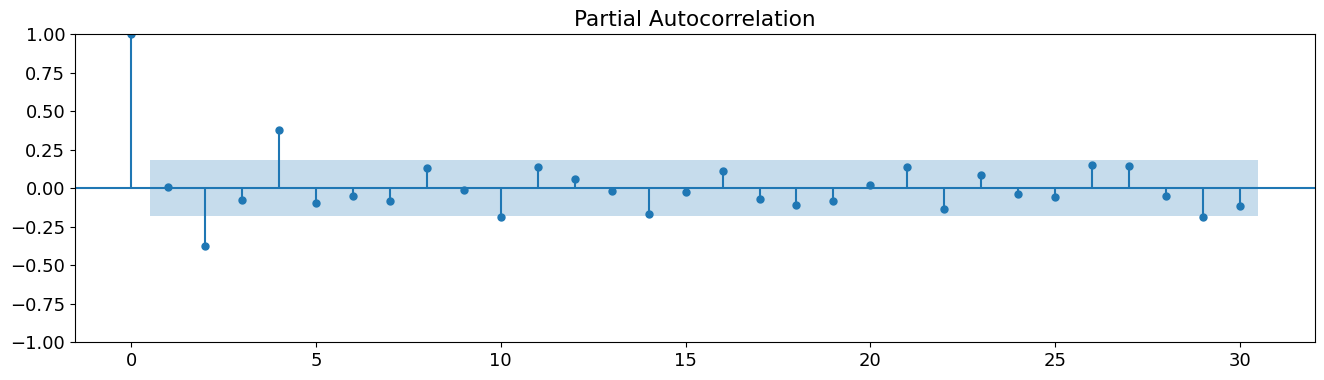

In [71]:
# Check ACF,PACF of the 1st_order differnencing
plt.figure(figsize=(15,6))
smt.graphics.tsa.plot_acf(train_log_diff, lags=30, alpha = 0.05)
smt.graphics.tsa.plot_pacf(train_log_diff, lags=30, alpha = 0.05)
plt.savefig("1diff Plot",bbox_inches = 'tight')

### Seasonal and Normal Differencing (d=1,D=1)

In [72]:
# There is an obvious seasonality in the plot, so we try to make the seasonal differnencing
train_log_s_diff = train_log_diff.diff(4)[4:]
train_log_s_diff

,0
Quarter,
1991-06-01,0.008561
1991-09-01,0.012701
1991-12-01,0.005783
1992-03-01,0.020097
1992-06-01,-0.080207
...,...
2017-12-01,0.001018
2018-03-01,0.001512
2018-06-01,-0.007722


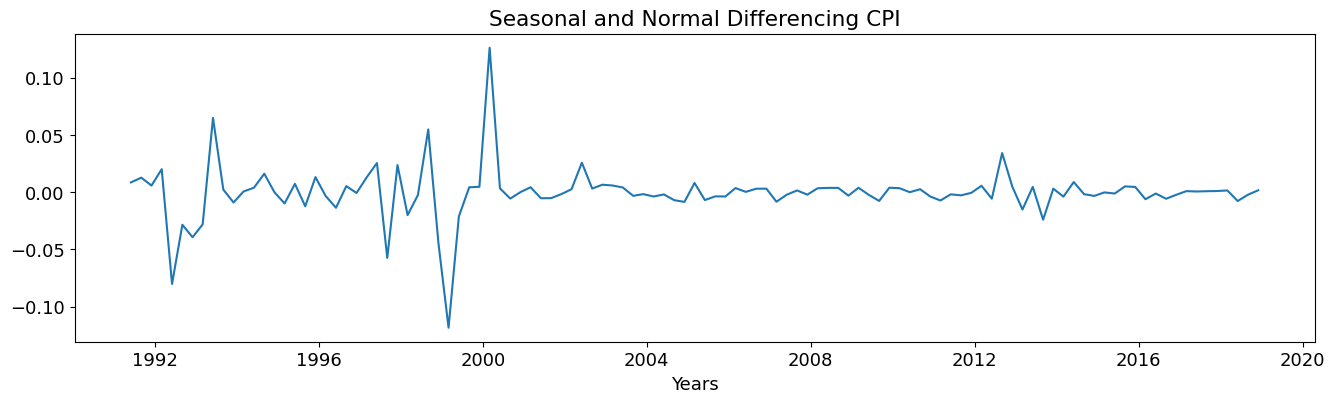

In [73]:
# Discard the nan value
train_log_s_diff = train_log_s_diff.dropna()

# Plot the differenced data
plt.figure()
plt.plot(train_log_s_diff)
plt.xlabel('Years')
plt.title('Seasonal and Normal Differencing CPI')
plt.savefig("sndiff",bbox_inches = 'tight')

<Figure size 1600x400 with 0 Axes>

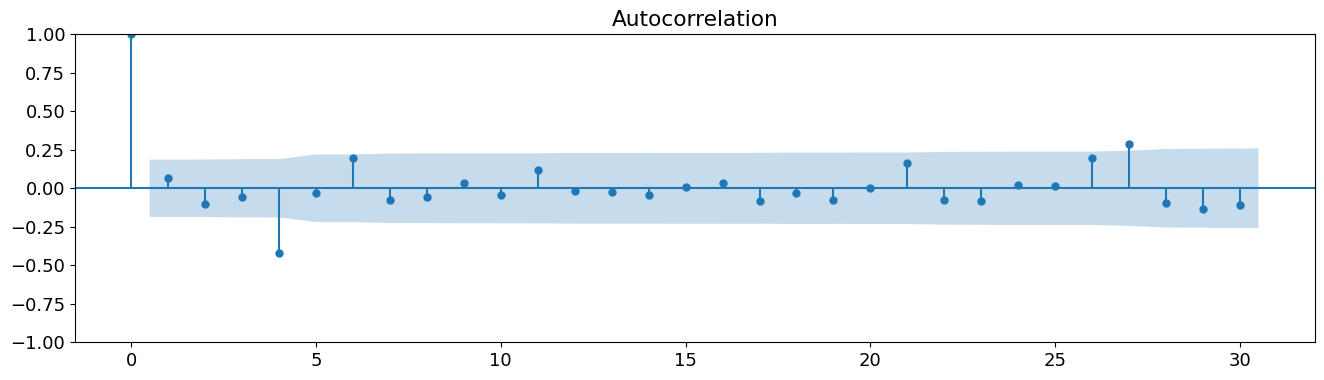

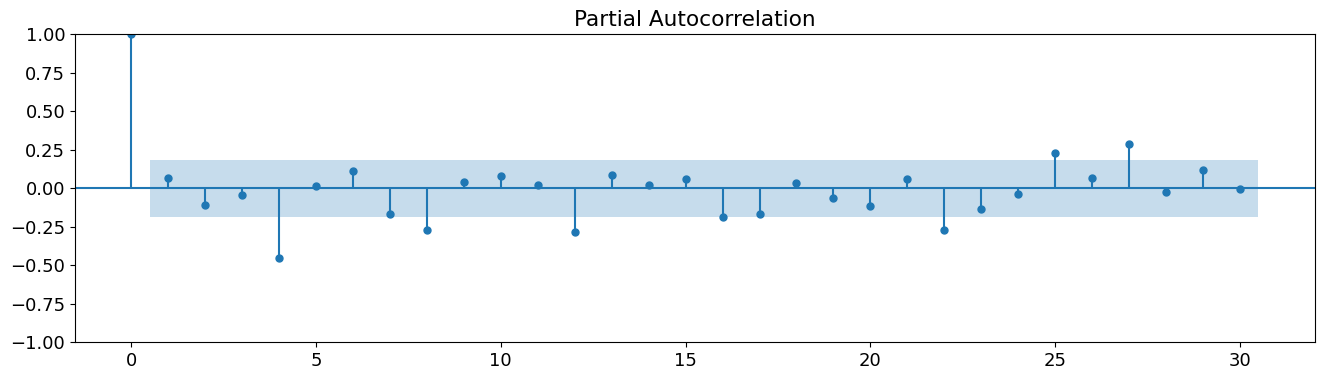

In [74]:
# Check ACF,PACF
plt.figure()
smt.graphics.tsa.plot_acf(train_log_s_diff, lags=30, alpha = 0.05)
smt.graphics.tsa.plot_pacf(train_log_s_diff, lags=30, alpha = 0.05)
plt.savefig("sndiff Plot",bbox_inches = 'tight')

#### From the ACF and PACF above, we can estimate the transformed data (d=1, D=1) has been stationary.
- We already know D=1, d=1.
- Q and q is decided by ACF: Q=1, q=0
- P and p is decided by PACF: P=0, p=0

So we get model SARIMA$(0,1,0)(0,1,1)_{4}$.

## Model fitting

In [75]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define a SARIMAX model
sarima_model = SARIMAX(train_set_log, 
                order = (0,1,0),
                seasonal_order = (1,1,1,4),
                enforce_stationarity = False,
                enforce_invertibility = False)

# Fit the SARIMAX model on train data
sarima_model_fit = sarima_model.fit()

# Forecast the CPI on test set
sarima_forecast1 = sarima_model_fit.forecast(len(validation_set))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


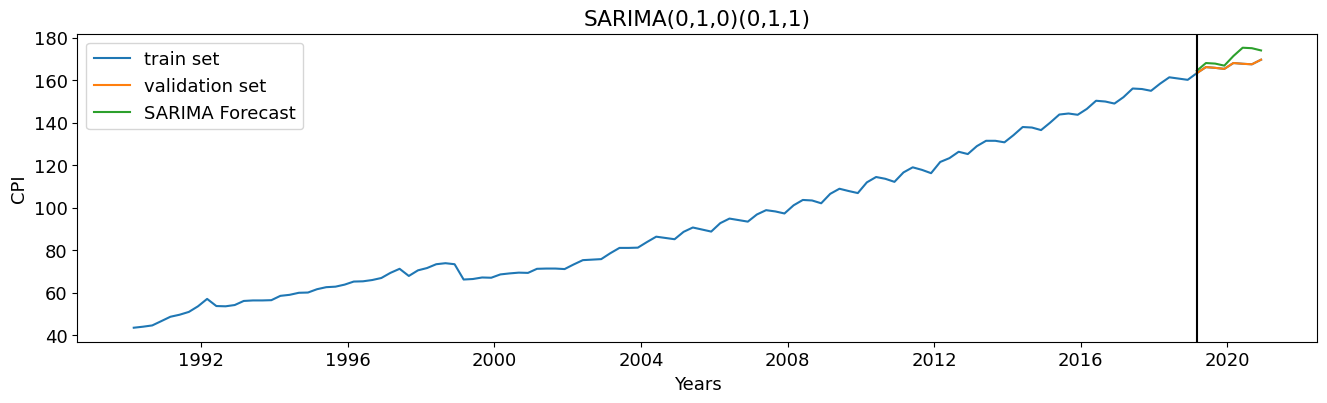

In [76]:
plt.figure()
plt.plot(train_df,label='train set')
plt.plot(validation_set,label='validation set')
plt.plot(np.exp(sarima_forecast1),label='SARIMA Forecast')
plt.title("SARIMA(0,1,0)(0,1,1)")
plt.xlabel("Years")
plt.ylabel("CPI")
plt.legend()
plt.axvline(x=train_df.index[len(train_set_log)],color='black')   # Make a vertical line indicating train/test separation
plt.savefig("sarima1",bbox_inches = 'tight')

In [77]:
# Calculate Mean Squared Error
from sklearn.metrics import mean_squared_error
MSE_SARIMA1 = mean_squared_error(validation_set,np.exp(sarima_forecast1))
MSE_SARIMA1 = MSE_SARIMA1.round(4)
MSE_SARIMA1

19.4459

## Use the Grid Search for other parameters in SARIMA

In [78]:
# Reference: https://docs.python.org/3/library/itertools.html
import itertools

# Set the range for every parameters
p = range(0, 4)  
d = range(0, 4)  
q = range(0, 4)  
P = range(0, 4)  
D = range(0, 4)  
Q = range(0, 4) 

# Create the lists for the combinations of parameters
param_combinations = list(itertools.product(p, d, q, P, D, Q))

# Set a maxmium MSE
best_mse = 100

# Loops through parameter combinations
for params in param_combinations:
    
    model = SARIMAX(train_set_log, order=(params[0], params[1], params[2]), seasonal_order=(params[3], params[4], params[5], 4))
    model_fit = model.fit()

    param_forcast = model_fit.forecast(len(validation_set))

    mse = mean_squared_error(validation_set, np.exp(param_forcast))

    if mse < best_mse:
        best_mse = mse
        best_params = params

print('Best params:', best_params)
print('Best MSE:', best_mse)

流式输出内容被截断，只能显示最后 5000 行内容。
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided

Best params: (3, 3, 3, 3, 0, 3)
Best MSE: 0.82642925229002


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [79]:
sarima_model2 = SARIMAX(train_set_log, 
                order = (3,3,3),
                seasonal_order = (3,0,3,4))

# Fit the SARIMAX model on train data
sarima_model_fit2 = sarima_model2.fit()

# Forecast the CPI on test set
sarima_forecast2 = sarima_model_fit2.forecast(len(validation_set))

sarima_forecast=np.exp(sarima_forecast2)
sarima_forecast

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2019-03-01    162.962964
2019-06-01    165.276903
2019-09-01    165.062468
2019-12-01    164.849210
2020-03-01    167.290005
2020-06-01    168.998634
2020-09-01    168.855482
2020-12-01    168.727355
Freq: QS-DEC, Name: predicted_mean, dtype: float64

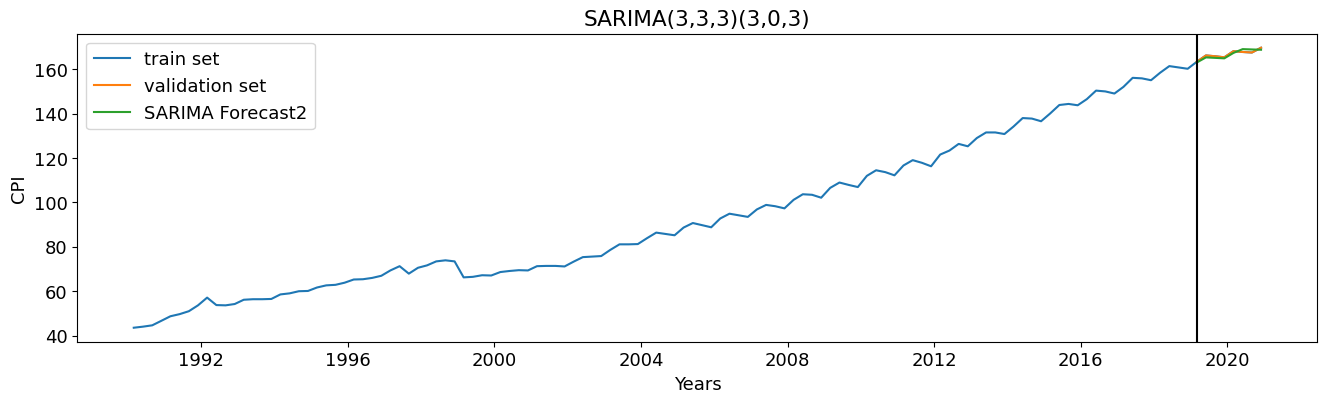

In [80]:
plt.figure()
plt.plot(train_df,label='train set')
plt.plot(validation_set,label='validation set')
plt.plot(sarima_forecast,label='SARIMA Forecast2')
plt.title("SARIMA(3,3,3)(3,0,3)")
plt.xlabel("Years")
plt.ylabel("CPI")
plt.legend()
plt.axvline(x=train_df.index[len(train_set_log)],color='black')   # Make a vertical line indicating train/test separation
plt.savefig("sarima2",bbox_inches = 'tight')

In [81]:
MSE_SARIMA2 = mean_squared_error(validation_set,sarima_forecast)
MSE_SARIMA2 = MSE_SARIMA2.round(4)
MSE_SARIMA2

0.8264

In [82]:
if MSE_SARIMA1 > MSE_SARIMA2:
    MSE_SARIMA = MSE_SARIMA2
else:
    MSE_SARIMA = MSE_SARIMA1
    
MSE_SARIMA

0.8264

# Neural network

In [83]:
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation,Dropout

In [84]:
import random as python_random
import tensorflow as tf
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(0)
# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(0)
# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
tf.random.set_seed(0)

In [85]:
train_set = pd.read_csv("CPI_train.csv")
train_set['Quarter'] = pd.to_datetime(train_set['Quarter'], format = '%Y-%m-%d')
train_set.set_index('Quarter', inplace = True)

train_set = train_set[:-8]
validation_set = train_set[-8:]

In [86]:
train = train_set.values
validation = validation_set.values

In [87]:
scaler = MinMaxScaler(feature_range = (0,1))
train = scaler.fit_transform(train.reshape(-1,1))

In [88]:
time_window = 6
Xtrain, Ytrain = [], []
for i in range(time_window, len(train)):
    Xtrain.append(train[i-time_window:i, 0]) # Access the accuracy
    Ytrain.append(train[i, 0])


In [89]:
Xtrain = np.array(Xtrain)
Ytrain = np.array(Ytrain)

In [90]:
model = Sequential()
model.add(Dense(30, input_dim = time_window, activation='relu'))
model.add(Dense(1))

In [91]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [92]:
model.fit(Xtrain, Ytrain, epochs=500, batch_size=20 , verbose=1,
          validation_split = 0.05)

Epoch 1/500
6/6 [==============================] - 5s 37ms/step - loss: 0.3709 - val_loss: 1.2485
Epoch 2/500
6/6 [==============================] - 0s 12ms/step - loss: 0.2561 - val_loss: 0.8723
Epoch 3/500
6/6 [==============================] - 0s 10ms/step - loss: 0.1722 - val_loss: 0.5675
Epoch 4/500
6/6 [==============================] - 0s 13ms/step - loss: 0.1052 - val_loss: 0.3522
Epoch 5/500
6/6 [==============================] - 0s 11ms/step - loss: 0.0593 - val_loss: 0.2103
Epoch 6/500
6/6 [==============================] - 0s 14ms/step - loss: 0.0327 - val_loss: 0.1155
Epoch 7/500
6/6 [==============================] - 0s 12ms/step - loss: 0.0166 - val_loss: 0.0616
Epoch 8/500
6/6 [==============================] - 0s 14ms/step - loss: 0.0093 - val_loss: 0.0322
Epoch 9/500
6/6 [==============================] - 0s 12ms/step - loss: 0.0061 - val_loss: 0.0167
Epoch 10/500
6/6 [==============================] - 0s 14ms/step - loss: 0.0053 - val_loss: 0.0096
Epoch 11/500
6/6 [=

In [93]:
dynamic_prediction = np.copy(train)

for i in range(len(train), len(train)+len(validation)):
    last_feature = np.reshape(dynamic_prediction[i-time_window:i], (1,time_window,1))
    next_pred = model.predict(last_feature)
    dynamic_prediction = np.append(dynamic_prediction, next_pred)
    
dynamic_prediction = dynamic_prediction.reshape(-1,1)
dynamic_prediction_original_scale = scaler.inverse_transform(dynamic_prediction)

1/1 [==============================] - 0s 18ms/step


In [94]:
dynamic_prediction_original_scale[-8:]

array([[163.50294172],
       [164.11708974],
       [165.97373593],
       [166.81510425],
       [167.82772713],
       [169.20999915],
       [170.48543901],
       [171.66052264]])

In [95]:
train_set = pd.read_csv("CPI_train.csv")
train_set['Quarter'] = pd.to_datetime(train_set['Quarter'], format = '%Y-%m-%d')
train_set.set_index('Quarter', inplace = True)

train = train_set[:-8]
validation = train_set[-8:]

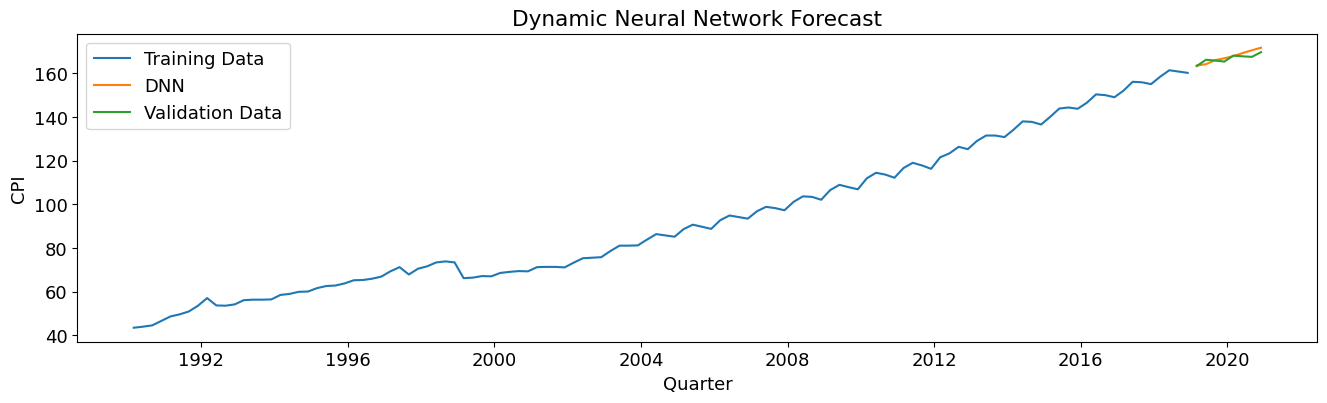

In [96]:
## test_index = np.arange(len(data_scaled) - test_size, len(data_scaled), 1)
nn = dynamic_prediction_original_scale[-len(validation):]
# plt.figure(figsize=(15,6))
plt.plot(train, label='Training Data')
plt.plot(validation.index, pd.DataFrame(nn), label='DNN') 
plt.plot(validation, label='Validation Data')
plt.legend(loc = "upper left")
plt.title('Dynamic Neural Network Forecast')
plt.xlabel('Quarter')
plt.ylabel('CPI')
plt.savefig("dn.png",dpi = 800)

# # Compute RMSE score on test data
# testScore = np.sqrt(mean_squared_error(Ytest, dynamic_prediction[-test_size:]))
# print('Dynamic Forecast RMSE: {0:.2f}'.format(testScore))

In [97]:
valid = np.asarray(validation)
nn = np.asarray(nn)

MSE_NN = MSE(valid,nn)
MSE_NN = MSE_NN.round(4)
MSE_NN

2.7458

# RNN (LSTM)

In [98]:
train_set = pd.read_csv("CPI_train.csv")
train_set['Quarter'] = pd.to_datetime(train_set['Quarter'], format = '%Y-%m-%d')
train_set.set_index('Quarter', inplace = True)

validation_set = train_set[-8:]
train_set = train_set[:-8]

In [99]:
train = train_set.values
validation = validation_set.values

In [100]:
scaler = MinMaxScaler(feature_range = (0,1))
train = scaler.fit_transform(train.reshape(-1,1))

In [101]:
time_window = 5
Xtrain, Ytrain = [], []
for i in range(time_window, len(train)):
    Xtrain.append(train[i-time_window:i, 0]) # Access the accuracy
    Ytrain.append(train[i, 0])
    
Xtrain = np.array(Xtrain)
Ytrain = np.array(Ytrain)

In [102]:
Xtrain = np.reshape(Xtrain,(Xtrain.shape[0],time_window,1))
Xtrain.shape

(111, 5, 1)

In [103]:
model = Sequential()
model.add(LSTM(units=64,input_shape = (time_window,1),activation = 'relu',return_sequences = False)) 
model.add(Dense(units=1))
model.add(Activation('linear'))
model.compile(loss="mean_squared_error", optimizer="rmsprop")
# model.summary()

In [104]:
model.fit(Xtrain, Ytrain, 
          batch_size = 8,             
          epochs = 500,               
          validation_split = 0.05, 
          shuffle = False,
          verbose = 1)

Epoch 1/500
14/14 [==============================] - 3s 50ms/step - loss: 0.0901 - val_loss: 0.2380
Epoch 2/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0301 - val_loss: 0.0807
Epoch 3/500
14/14 [==============================] - 0s 26ms/step - loss: 0.0126 - val_loss: 0.0150
Epoch 4/500
14/14 [==============================] - 0s 27ms/step - loss: 0.0110 - val_loss: 0.0013
Epoch 5/500
14/14 [==============================] - 0s 29ms/step - loss: 0.0102 - val_loss: 1.4760e-04
Epoch 6/500
14/14 [==============================] - 0s 24ms/step - loss: 0.0078 - val_loss: 6.9546e-04
Epoch 7/500
14/14 [==============================] - 0s 13ms/step - loss: 0.0054 - val_loss: 0.0012
Epoch 8/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 9/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 10/500
14/14 [==============================] - 0s 14ms/step - loss: 0.0013 - val_loss

In [105]:
dynamic_prediction = np.copy(train)

for i in range(len(train), len(train)+len(validation)):
    last_feature = np.reshape(dynamic_prediction[i-time_window:i], (1,time_window,1))
    next_pred = model.predict(last_feature)
    dynamic_prediction = np.append(dynamic_prediction, next_pred)
    
dynamic_prediction = dynamic_prediction.reshape(-1,1)
dynamic_prediction_original_scale = scaler.inverse_transform(dynamic_prediction)

1/1 [==============================] - 0s 20ms/step


In [106]:
dynamic_prediction_original_scale[-8:]

array([[162.66410198],
       [164.01409257],
       [165.0990888 ],
       [165.93704354],
       [166.94451095],
       [168.15302793],
       [169.18728415],
       [170.17410154]])

In [107]:
train_set = pd.read_csv("CPI_train.csv")
train_set['Quarter'] = pd.to_datetime(train_set['Quarter'], format = '%Y-%m-%d')
train_set.set_index('Quarter', inplace = True)

train = train_set[:-8]
validation = train_set[-8:]

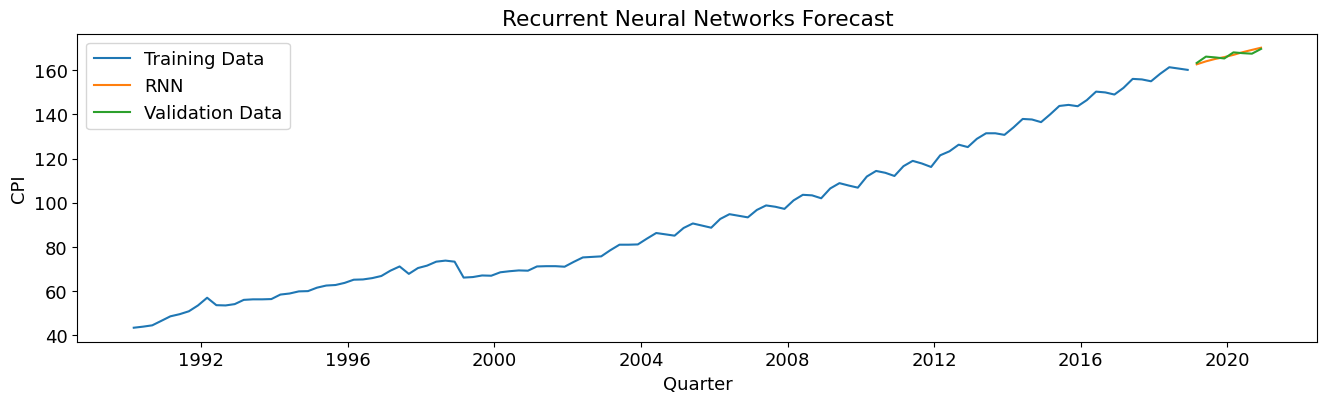

In [108]:
## test_index = np.arange(len(data_scaled) - test_size, len(data_scaled), 1)
rnn = dynamic_prediction_original_scale[-len(validation):]
# plt.figure(figsize=(15,6))
plt.plot(train, label='Training Data')
plt.plot(validation.index, pd.DataFrame(rnn), label='RNN') 
plt.plot(validation, label='Validation Data')
plt.legend(loc = "upper left")

plt.title('Recurrent Neural Networks Forecast')
plt.xlabel('Quarter')
plt.ylabel('CPI')

plt.savefig('rnn.png',dpi = 800)
plt.show()

In [109]:
valid = np.asarray(validation)
rnn = np.asarray(rnn)

MSE_LSTM = MSE(valid,rnn)
MSE_LSTM = MSE_LSTM.round(4)
MSE_LSTM

1.3146

# Model Selection

In [110]:
# Compare the MSE of each model
columns = ['Decomp', 'Seasonal_Naive', 'Drift', 'HW_add', 'HW_mul', 'SARIMA', 'NN', 'RNN']
MSEs = [MSE_decomp, MSE_naive, MSE_drift, MSE_HW_add, MSE_HW_mul, MSE_SARIMA, MSE_NN, MSE_LSTM]
forecasts = pd.DataFrame(MSEs, index = columns, columns = ['MSE'])
forecasts

,MSE
Decomp,43.8428
Seasonal_Naive,46.1538
Drift,5.0465
HW_add,6.7167
HW_mul,7.8762
SARIMA,0.8264
NN,2.7458
RNN,1.3146


# Forecast Combinations

In [111]:
# The average of the two models combined
forecast_combination_1 = (sarima_forecast.values + rnn)/2
validation = np.asarray (validation)
forecast_combination_1 = np.asarray (forecast_combination_1)
MSE_forecast_1 = MSE(validation, forecast_combination_1)
MSE_forecast_1.round(4)

2.0211

In [112]:
# The weighted average of the two models combined
forecast_combination_2 = rnn * MSE_LSTM / (MSE_SARIMA + MSE_LSTM) + sarima_forecast.values * MSE_SARIMA / (MSE_SARIMA + MSE_LSTM)
validation = np.asarray (validation)
MSE_forecast_2 = MSE(validation, forecast_combination_2)
MSE_forecast_2.round(4)

1.4034

# Forecasts

In [124]:
train_df_log = np.log(train_df)

# Derive the final 8 predicted values
best_model = SARIMAX(train_df_log, 
                order = (3,3,3),
                seasonal_order = (3,0,3,4))

# Fit the SARIMAX model on train data
best_model_fit = best_model.fit()

# Forecast the CPI on test set
best_forecast = best_model_fit.forecast(len(test_df))

best_forecast = np.exp(best_forecast)

best_forecast = np.asarray(best_forecast).round(4)
best_forecast = pd.DataFrame(best_forecast, index=test_df.index, columns = ['forecast'])
best_forecast

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,forecast
Quarter,
2021-03-01,171.9933
2021-06-01,172.6289
2021-09-01,173.3559
2021-12-01,174.4936
2022-03-01,176.3127
2022-06-01,176.9377
2022-09-01,177.7906
2022-12-01,179.0410


In [125]:
test = pd.read_csv('CPI_test.csv')
test.shape
test

,Quarter,CPI
0,3/1/2021,127
1,6/1/2021,128
2,9/1/2021,129
3,12/1/2021,130
4,3/1/2022,131
5,6/1/2022,132
6,9/1/2022,133
7,12/1/2022,134


In [126]:
# replace test
best_forecast = np.asarray(best_forecast).round(4)
test['CPI'] = best_forecast
test

,Quarter,CPI
0,3/1/2021,171.9933
1,6/1/2021,172.6289
2,9/1/2021,173.3559
3,12/1/2021,174.4936
4,3/1/2022,176.3127
5,6/1/2022,176.9377
6,9/1/2022,177.7906
7,12/1/2022,179.0410


In [129]:
# save as csv file
test.to_csv('Group_60_forecast.csv', index=False)

In [130]:
new_test = pd.read_csv('Group_60_forecast.csv')
new_test

,Quarter,CPI
0,3/1/2021,171.9933
1,6/1/2021,172.6289
2,9/1/2021,173.3559
3,12/1/2021,174.4936
4,3/1/2022,176.3127
5,6/1/2022,176.9377
6,9/1/2022,177.7906
7,12/1/2022,179.0410
